San Mateo Election Analysis
===========================

The city of San Mateo has an [open data platform](https://data.smcgov.org/) in which it publishes its election rolls and many other items.  

The goal of this notebook is both as a technology learning exercise and a demonstration and exploration of what can be done with this public data.  The technology aspect lies on several layers -- a part that is related to the interface with the external government server using the Socrata API, a part that is related to data analysis tooling that is apparent in the text of this notebook, and a third part that is a layer behind the ipython notebook -- see note below.  

The Socrata API has been adopted by many government agencies at the municipal, state, and federal level.  It provides a more or less standardized way to access data via a REST endpoint.  There are SQL-like query facilities in the API.

---

### Library Imports

In [1]:
# key DS library imports
import numpy as np
import pandas as pd
import datetime
import urllib


In [2]:
# Visualization with altair
import altair as alt
alt.renderers.enable('notebook')
#alt.renderers.enable('jupyterlab')

RendererRegistry.enable('notebook')

---

### Information Retrieval

The [Socrata API](https://dev.socrata.com/consumers/getting-started.html) is called "SODA" and has the following search terms:

* limit - this is a limit on the number of rows collected with a max of 50k
* offset - this is the starting row index, which is useful for paging
* _any data column_ - can be used to subset the data with an equality filter
* query - this can be used as a single string or as a piecemeal query as described [here](https://dev.socrata.com/docs/queries/)

This particular data set has the following [fields](https://data.smcgov.org/Government/Election-results/chpj-588r):

* Date	
* Precinct Name	
* Split Name	
* Precinct Split Id	
* Registered Voters	
* Ballots	
* Reporting	
* Contest Id	
* Contest Title	
* Contest Party	
* Choice Id	
* Candidate Name	
* Choice Party	
* Candidate Type	
* Absentee Votes	
* Early Votes	
* Election Votes	
* Count

In [66]:
# Socratta API query
query = ("https://data.smcgov.org/resource/ywbb-f2bb.json?"
         "&$limit=10000")

raw_data = pd.read_json(query)

In [77]:
query = ("https://data.smcgov.org/resource/ywbb-f2bb.json?"
         "&$group=contest_title,date"
         "&$select=contest_title,sum(election_votes),sum(absentee_votes),"
                  "sum(early_votes),sum(registered_voters),date%20AS%20DATE"
         "&$limit=20000")

contest_types = pd.read_json(query)

In [38]:
query = ("https://data.smcgov.org/resource/ywbb-f2bb.json?"
         "&contest_title=12TH%20CONGRESSIONAL%20DISTRICT"
         "&$limit=20000")

congress_votes = pd.read_json(query)

---

### Data Validation and Exploration


In [67]:
raw_data.iloc[0:20]

,absentee_votes,ballots,candidate_name,candidate_type,choice_id,choice_party,contest_id,contest_party,contest_title,count,date,early_votes,election_votes,precinct_name,precinct_split_id,registered_voters,reporting,split_name
0,79,464,YES,C,141,NaN,28,NaN,PROPOSITION 91,1,2008-02-01,2,82,1015,566,683,1,0
1,213,671,NO,C,142,NaN,28,NaN,PROPOSITION 91,1,2008-02-01,2,129,1401,582,990,1,0
2,133,526,YES,C,141,NaN,28,NaN,PROPOSITION 91,1,2008-02-01,1,70,1507,599,801,1,0
3,2,37,NO,C,146,NaN,30,NaN,PROPOSITION 93,1,2008-02-01,3,11,1701,635,49,1,0
4,94,426,NO,C,150,NaN,32,NaN,PROPOSITION 95,1,2008-02-01,1,109,2103,669,788,1,0
5,108,523,YES,C,141,NaN,28,NaN,PROPOSITION 91,1,2008-02-01,4,82,2112,678,777,1,0
6,198,724,NO,C,148,NaN,31,NaN,PROPOSITION 94,1,2008-02-01,1,179,2115,681,1044,1,0
7,99,558,YES,C,141,NaN,28,NaN,PROPOSITION 91,1,2008-02-01,5,92,2117,682,1045,1,0
8,102,487,YES,C,141,NaN,28,NaN,PROPOSITION 91,1,2008-02-01,1,80,2208,695,790,1,0
9,131,609,YES,C,141,NaN,28,NaN,PROPOSITION 91,1,2008-02-01,0,123,2222,706,929,1,0


---

### Data Processing and Visualization


In [70]:
contest_types['total_votes'] = contest_types.sum_absentee_votes + contest_types.sum_early_votes + contest_types.sum_election_votes

In [71]:
propositions = contest_types.loc[contest_types.contest_title.str.startswith('PROPOSITION')] \
                            .sort_values(by='total_votes', ascending=False)

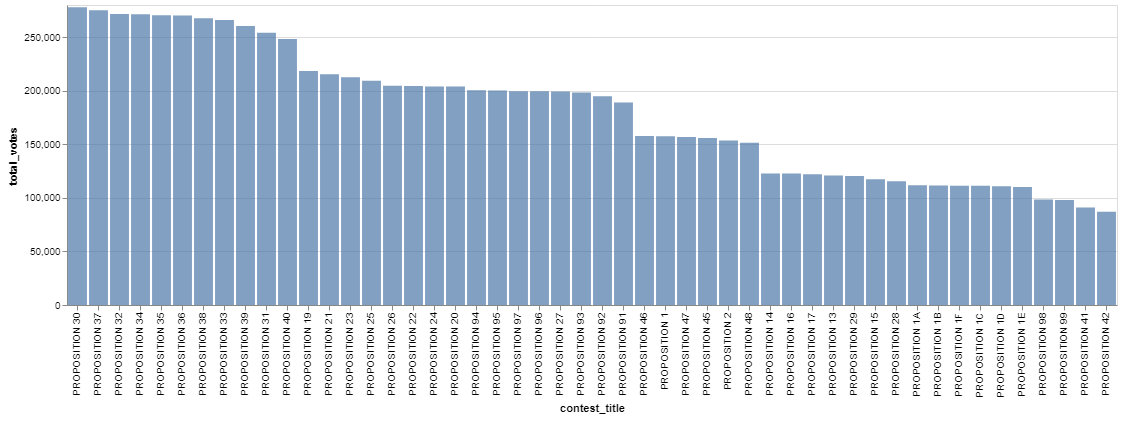

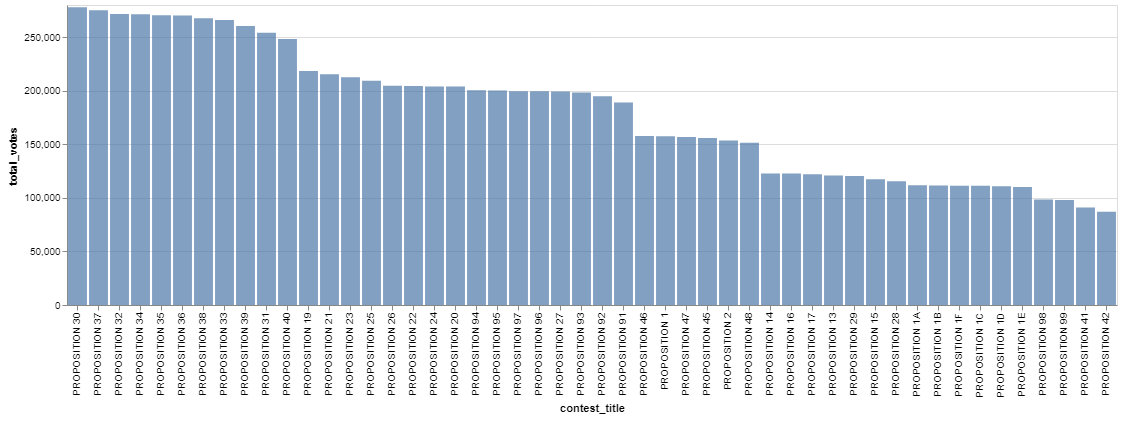

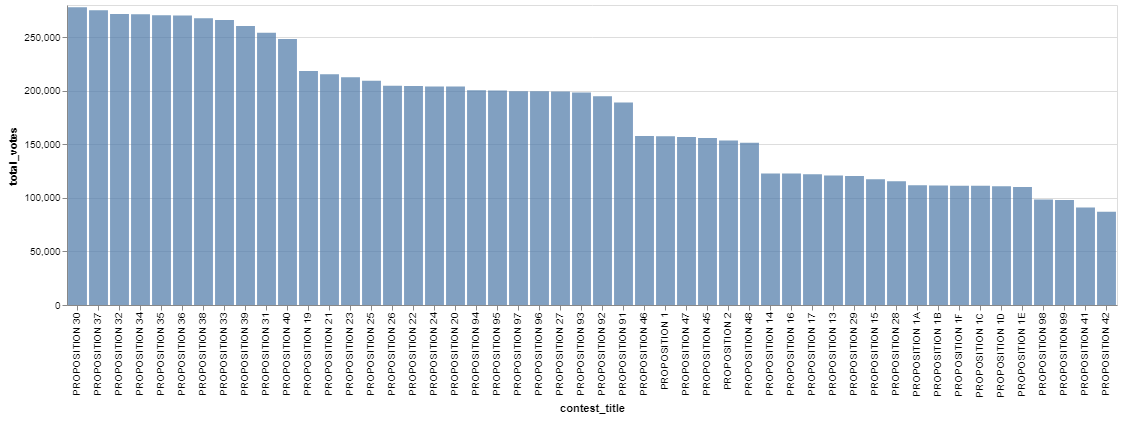

In [72]:
source = propositions

alt.Chart(source).mark_bar(opacity=0.7).encode(
    alt.X('contest_title', sort=alt.SortField(field='total_votes', 
                                              order='descending', op='sum')),
    alt.Y('total_votes')
)

In [75]:
propositions[0:6]

,DATE,contest_title,sum_absentee_votes,sum_early_votes,sum_election_votes,sum_registered_voters,total_votes
314,2012-11-01,PROPOSITION 30,159927,3395,114652,722972,277974
360,2012-11-01,PROPOSITION 37,158466,3372,113195,722972,275033
452,2012-11-01,PROPOSITION 32,157127,3336,111252,722972,271715
173,2012-11-01,PROPOSITION 34,156593,3332,111471,722972,271396
286,2012-11-01,PROPOSITION 35,156367,3315,110703,722972,270385
295,2012-11-01,PROPOSITION 36,156402,3326,110428,722972,270156


In [76]:
propositions[-7:-1]

,DATE,contest_title,sum_absentee_votes,sum_early_votes,sum_election_votes,sum_registered_voters,total_votes
409,2009-05-01,PROPOSITION 1C,71558,494,39153,721564,111205
81,2009-05-01,PROPOSITION 1D,71253,495,39122,721564,110870
353,2009-05-01,PROPOSITION 1E,70744,496,38940,721564,110180
110,2008-06-01,PROPOSITION 98,63509,254,34729,720036,98492
323,2008-06-01,PROPOSITION 99,63218,253,34473,720036,97944
198,2014-06-01,PROPOSITION 41,70458,422,20097,709988,90977


### Most voted initiatives

* Prop 30 - (Pass) Sales and Income Tax Increase, Millionare's Tax
* Prop 37 - (Fail) Mandatory Labeling of GMO foods
* Prop 32 - (Fail) Paycheck protection initiative - ban union contributions to politics
* Prop 34 - (Fail) End the Death Penalty
* Prop 35 - (Pass) Stronger penalties on human trafficking and sex slavery
* Prop 36 - (Pass) Changes to the 3-strikes law

### Least voted initiatives

* Prop 1c - (Fail) Borrowing against future lottery proceeds
* Prop 1d - (Pass) Bond for education
* Prop 1e - (Fail) Mental health revenue fund shift
* Prop 98 - (Fail) Emininent Domain and Rent Control
* Prop 99 - (Pass) Rules governing eminent domain
* Prop 41 - (Pass) Veterans housing urban development programs


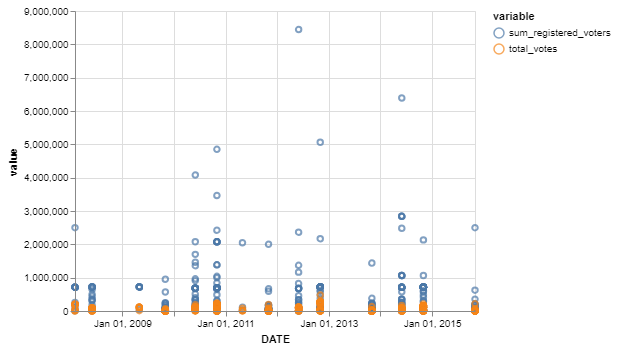

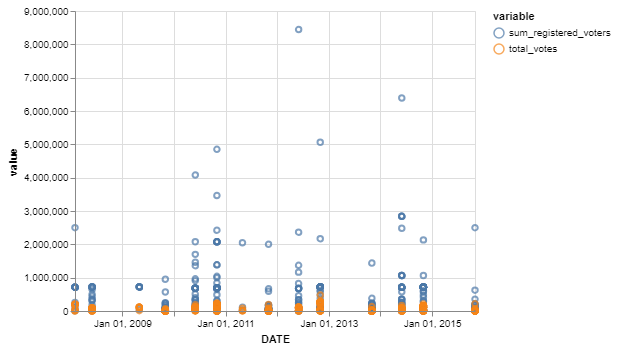

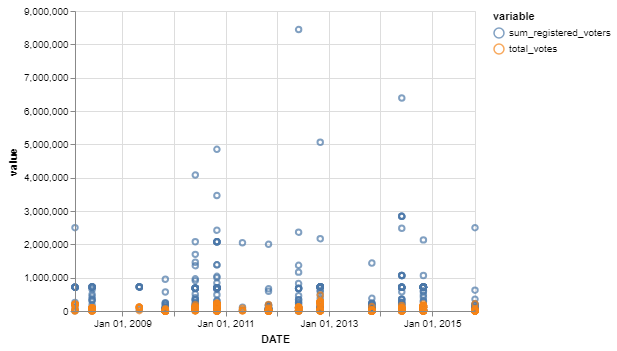

In [74]:
source = contest_types[['DATE', 'sum_registered_voters', 'total_votes']].melt(id_vars=['DATE'])

alt.Chart(source).mark_point().encode(
    alt.X('DATE'),
    alt.Y('value'),
    color='variable'
)

---

Method and Notes
================

- The Socrata API docs presume that you understand how characters like spaces, dashes, etc., are translated into HTML friendly characters.  Therefore, the API requires things like `group=This%20is%20a%20test`

